## Importing Libraries & Data

In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from wordcloud import WordCloud
from scipy.stats import pearsonr

Mapping the category_id of each video to its category in the code below

In [203]:
df = pd.read_csv('youtube_data.csv')


categories = pd.read_csv('youtube_categories.csv')
categories.head()

df = df.merge(categories, on = 'category_id', how = 'left')
df = df.drop_duplicates(subset = 'video_id')

In [204]:
df.head()

,published_at,video_id,channel_id,title,channel_title,view_count,like_count,comment_count,tags,duration,category_id,timestamp,category_title
0,2023-04-17 16:00:14,3inw26U-os4,UCKsN6xyJ2w8g7p4p9apXkYQ,Grupo Frontera x Bad Bunny - un x100to (Video ...,Grupo Frontera,18533453,978908,30640,"['bad bunny', 'grupo frontera', 'frontera', 'f...",3.250000,10,2023-04-19 10:53:26.617027,Music
1,2023-04-18 21:10:35,yRCzziLUvYs,UCET00YnetHT7tOpu12v8jxg,Chelsea vs. Real Madrid: Extended Highlights |...,CBS Sports Golazo,803230,9056,1117,"['Champions League', 'Europa League', 'Soccer'...",11.750000,17,2023-04-19 10:53:26.617027,Sports
2,2023-04-19 05:45:07,gUmE_TRdp0s,UCJ0uqCI0Vqr2Rrt1HseGirg,BLACKPINK Carpool Karaoke,The Late Late Show with James Corden,3456456,495906,18189,"['The Late Late Show', 'Late Late Show', 'Jame...",14.366667,24,2023-04-19 10:53:26.617027,Entertainment
3,2023-04-18 15:00:30,QxS7KDYQBWs,UC071KjEQUoDUe3FvDU6j02Q,Freestyle with Love is Blind’s Marshall Glaze ...,Nick Viall,267261,6265,1348,"['nick viall', 'bachelor', 'abc', 'viall files...",92.783333,22,2023-04-19 10:53:26.617027,People & Blogs
4,2023-04-18 04:30:35,koHXg0PlYq8,UC9-OpMMVoNP5o10_Iyq7Ndw,Draymond Ejected After STEPPING On Sabonis 😳,Bleacher Report,683683,3665,3691,"['bleacher report', 'br', 'nba', 'basketball',...",0.966667,17,2023-04-19 10:53:26.617027,Sports


In [205]:
df.dtypes

published_at       object
video_id           object
channel_id         object
title              object
channel_title      object
view_count          int64
like_count          int64
comment_count       int64
tags               object
duration          float64
category_id         int64
timestamp          object
category_title     object
dtype: object

Converting string representation of lists to lists

In [206]:
df['tags'] = df['tags'].apply(lambda x: eval(x))

## Measuring Video Engagment and Observing Its Trends

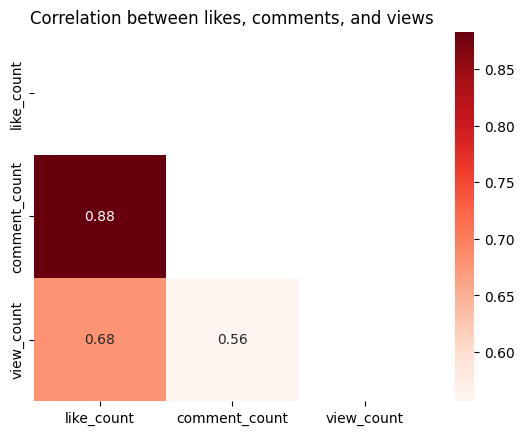

In [220]:
corr = df[['like_count', 'comment_count', 'view_count']].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot = True, cmap = 'Reds', mask = mask);
plt.title('Correlation between likes, comments, and views');

As shown in the correlation heatmap, comments have a moderate, positive correlation with view count. Like count and view count have a moderately strong, positive correlation. Finally like count and comment count have a strong, positive correlation. Since these variables are all correlated, they will be used to create a new metric, engagement.

Measuring engagement:

- engagement = likes + comments / views

This is an attempt to measure how engaging a video is. An assumption being made is that engaging videos will have more likes and comments per a certain number of views. This metric helps highlight videos that are engaging (having a lot of likes and comments), but have less views than a video with a lot of views, but very few comments and likes.

In [225]:
df['engagement'] = (df['like_count'] + df['comment_count']) / df['view_count']

Video categories with the most engagment

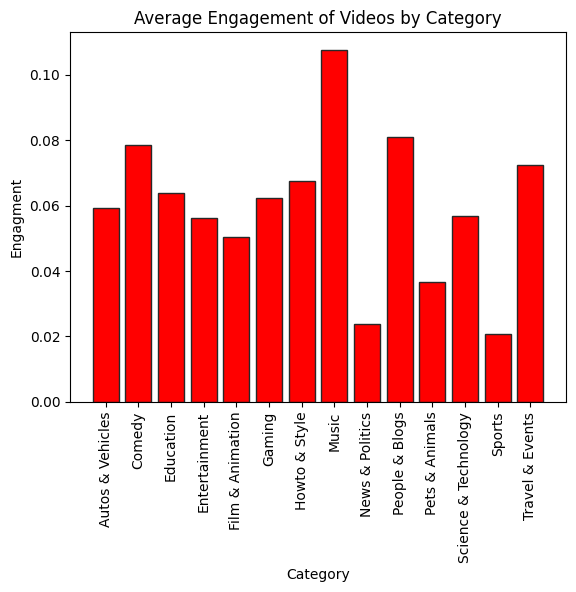

In [ ]:
agg_cat = df.groupby('category_title')['engagement'].mean()
plt.bar(x = agg_cat.index, height = agg_cat, color = "#FF0000", edgecolor = '#282828');
plt.xticks(rotation=90);
plt.xlabel('Category');
plt.ylabel('Engagment');
plt.title('Average Engagement of Videos by Category');

It seems that videos under the category "Music" have the highest engagement

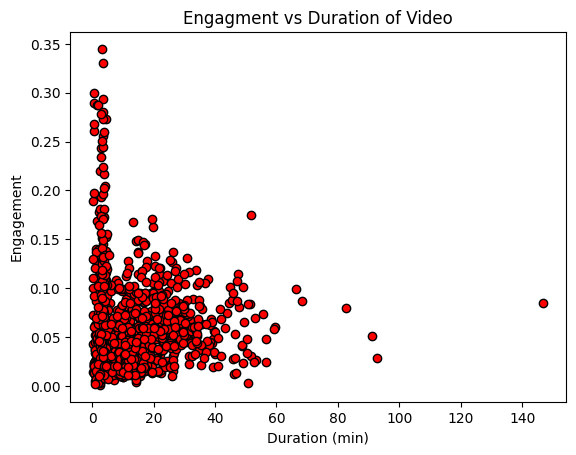

In [ ]:
plt.scatter(x = df.duration, y = df.engagement, edgecolors = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Engagement');
plt.title('Engagment vs Duration of Video');

Looking at the scatterplot, it is possible that shorter videos tend to have a higher engagment on average, but a different visualization may help us make more accurate interpretations.

In [279]:
#removing outliers to bin data by duration appropriately
q1 = df.duration.quantile(0.25)
q3 = df.duration.quantile(0.75)
iqr = q3 - q1

lower_thresh = q1 - (1.5 * iqr)
upper_thresh = q3 + (1.5 * iqr)

is_not_outlier = (df['duration'] >= lower_thresh) & (df['duration'] <= upper_thresh)
df_no_outliers = df[is_not_outlier][['engagement', 'duration']].copy()

In [302]:
bins = list(range(0, 46, 5))
df_no_outliers['duration_bin'] = pd.cut(df_no_outliers['duration'], bins)
grouped_bins = df_no_outliers.groupby('duration_bin').mean().reset_index()

In [303]:
grouped_bins

,duration_bin,engagement,duration
0,"(0, 5]",0.077964,2.836780
1,"(5, 10]",0.035555,8.225880
2,"(10, 15]",0.050658,12.368699
3,"(15, 20]",0.061141,17.192042
4,"(20, 25]",0.064137,22.222031
5,"(25, 30]",0.064679,27.092157
6,"(30, 35]",0.065589,32.524275
7,"(35, 40]",0.052664,37.910145
8,"(40, 45]",0.063152,42.622222


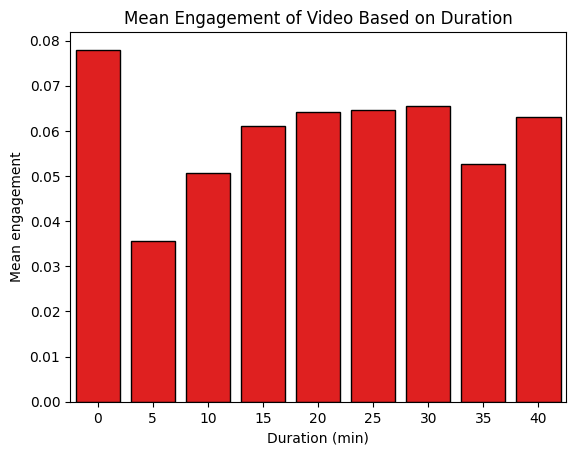

In [331]:
sns.barplot(x = x_ticks, y = grouped_bins.engagement, edgecolor = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Mean engagement');
plt.title('Mean Engagement of Video Based on Duration');

In [224]:
df.columns

Index(['published_at', 'video_id', 'channel_id', 'title', 'channel_title',
       'view_count', 'like_count', 'comment_count', 'tags', 'duration',
       'category_id', 'timestamp', 'category_title'],
      dtype='object')

## When is the best time to upload a video?

In [ ]:
time_df = df[['published_at', 'view_count', 'like_count', 'comment_count', 'engagement']].copy()
time_df['published_at'] = pd.to_datetime(time_df['published_at'])

In [ ]:
time_df_hour = time_df.groupby(time_df['published_at'].dt.hour)[['view_count', 'like_count', 'comment_count']].mean()

In [ ]:
time_df_hour

,view_count,like_count,comment_count
published_at,,,
0,1.675165e+06,140699.945946,9976.135135
1,4.794921e+05,22806.720000,2315.560000
2,9.211460e+05,23742.741935,2304.483871
3,1.995045e+06,139675.030303,16843.575758
4,1.168343e+06,79107.661290,4837.951613
5,1.021504e+06,54094.588235,3808.117647
6,7.718002e+05,29906.692308,3650.769231
7,5.610495e+05,10103.250000,1186.500000
8,9.711370e+06,401567.400000,33584.000000
